In [1]:
import sys
import os
import sympy as sp
import numpy as np

# Add the correct path to the P2 folder
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..','..')))

from gauss_fehlerfortpflanzung import evaluate_gaussian_error
from geraden_fit import geraden_fit
from scientific_error_rounder import runden_und_speichern
from mean_calc_w_err import err_weighted_mean

In [5]:
import sympy as sp
from gauss_fehlerfortpflanzung import gaussian_error_propagation

def check_premisse(input_file):
    # Datei einlesen
    with open(input_file, 'r') as file:
        lines = file.readlines()

    # Überspringe die erste Zeile (Spaltennamen)
    data = [line.split() for line in lines[1:]]

    # Konvertiere Werte zu float oder None
    parsed_data = [[float(val) if val != 'None' else None for val in row] for row in data]

    # Extrahiere Werte und Fehler
    n_values = 5  # Anzahl der Werte pro Kategorie
    categories = ['t_up', 't_mid', 't_down']

    # Symbole definieren (außerhalb der Schleife)
    t_up_mean, t_mid_mean, t_down_mean = sp.symbols('t_up_mean t_mid_mean t_down_mean')
    formula = 2 * 0.0002 / t_mid_mean - (0.0002 / t_down_mean - 0.0002 / t_up_mean)  # Beispiel

    for row_idx, row in enumerate(parsed_data):
        print(f"\nZeile {row_idx + 1}:")
        
        # Werte und Fehler für jede Kategorie extrahieren
        t_up_values = [row[j] for j in range(0, 10, 2)]
        t_up_errors = [row[j] for j in range(1, 10, 2)]
        t_mid_values = [row[j] for j in range(10, 20, 2)]
        t_mid_errors = [row[j] for j in range(11, 20, 2)]
        t_down_values = [row[j] for j in range(20, 30, 2)]
        t_down_errors = [row[j] for j in range(21, 30, 2)]

        # Iteriere über die Wertepaare
        for k in range(n_values):
            values = [t_up_values[k], t_mid_values[k], t_down_values[k]]
            errors = [t_up_errors[k], t_mid_errors[k], t_down_errors[k]]

            # Überspringe, wenn ein Wert fehlt
            if None in values or None in errors:
                continue

            # Debugging: Werte und Fehler prüfen
            #print(f"Werte: {values}, Fehler: {errors}")

            # Variablen und Werte für die Fehlerfortpflanzung
            variables = [
                [t_up_mean, values[0], errors[0]],
                [t_mid_mean, values[1], errors[1]],
                [t_down_mean, values[2], errors[2]],
            ]

            # Fehlerfortpflanzung berechnen
            try:
                    gaussian_error_propagation(
                    formula=formula,
                    variables=variables,
                    output=True # Annahme: Ausgabe wird benötigt
                )
            except Exception as e:
                print(f"Fehler bei der Berechnung: {e}")


# Beispiel: Datei verarbeiten
check_premisse('c_mess_raw.txt')



Zeile 1:
Formel: 0.0002/t_up_mean + 0.0004/t_mid_mean - 0.0002/t_down_mean
Werte: [[t_up_mean, 6.68, 0.3], [t_mid_mean, 4.57, 0.3], [t_down_mean, 2.54, 0.3]] 

Formelwert: 0.0000387273145777571

Fehlerformel: sqrt((-0.0002*del_t_up_mean/t_up_mean**2)**2 + (-0.0004*del_t_mid_mean/t_mid_mean**2)**2 + (0.0002*del_t_down_mean/t_down_mean**2)**2)
Fehler: 0.0000110141864870844 
Ergebnis: 0.0±0.0

Zeile 2:
Formel: 0.0002/t_up_mean + 0.0004/t_mid_mean - 0.0002/t_down_mean
Werte: [[t_up_mean, 1.07, 0.3], [t_mid_mean, 4.87, 0.3], [t_down_mean, 0.75, 0.3]] 

Formelwert: 0.00000238474479776366

Fehlerformel: sqrt((-0.0002*del_t_up_mean/t_up_mean**2)**2 + (-0.0004*del_t_mid_mean/t_mid_mean**2)**2 + (0.0002*del_t_down_mean/t_down_mean**2)**2)
Fehler: 0.000118952935798264 
Ergebnis: 0.0±0.0001
Formel: 0.0002/t_up_mean + 0.0004/t_mid_mean - 0.0002/t_down_mean
Werte: [[t_up_mean, 1.19, 0.3], [t_mid_mean, 5.98, 0.3], [t_down_mean, 0.97, 0.3]] 

Formelwert: 0.0000287712919874704

Fehlerformel: sqrt((-0.

In [6]:
def process_results_to_table(input_file, output_file):
    with open(input_file, 'r') as file:
        lines = file.readlines()

    results = []
    current_line_results = []

    for line in lines:
        line = line.strip()

        # Erkenne neue Zeile basierend auf dem Header
        if line.startswith("Zeile"):
            if current_line_results:
                # Fülle auf 5 Ergebnisse mit None, falls weniger vorhanden
                while len(current_line_results) < 5:
                    current_line_results.append((None, None))
                results.append(current_line_results)
                current_line_results = []
        elif line.startswith("Formelwert:"):
            # Extrahiere den Formelwert
            formula_value = float(line.split(":")[1].strip())
        elif line.startswith("Fehler:"):
            # Extrahiere den Fehler
            error_value = float(line.split(":")[1].strip())
            current_line_results.append((formula_value, error_value))

    # Letzte Zeile hinzufügen, falls sie nicht leer ist
    if current_line_results:
        while len(current_line_results) < 5:
            current_line_results.append((None, None))
        results.append(current_line_results)

    # Schreibe die Ergebnisse in eine neue Datei
    with open(output_file, 'w') as file:
        # Spaltennamen erstellen
        header = []
        for i in range(1, 6):
            header.append(f"Formelwert_{i}")
            header.append(f"Fehler_{i}")
        file.write("\t".join(header) + "\n")

        # Ergebnisse Zeile für Zeile schreiben
        for result in results:
            row = []
            for value, error in result:
                row.append(f"{value:.6f}" if value is not None else "None")
                row.append(f"{error:.6f}" if error is not None else "None")
            file.write("\t".join(row) + "\n")

    print(f"Ergebnisse erfolgreich in '{output_file}' gespeichert.")

# Beispielaufruf
input_file = "c_check.txt"  # Die Datei mit dem zwischengespeicherten Output
output_file = "c_Korrektur_resultat.txt"  # Datei für die vereinfachten Ergebnisse
process_results_to_table(input_file, output_file)



Ergebnisse erfolgreich in 'c_Korrektur_resultat.txt' gespeichert.


Aus der Korrektur entnehmen wir, dass die folgenden Werte verworfen werden muessen:
Tropfen Reihe
1 1
3 1
8 1
13 1

(14 [2, 3, 5])
(15 1)

Für die Tropfen 14 und 15 sind dabei die Abweichungen (mit abgezogenem Fehler) so gering, dass wir eher auf einen sehr geringen nicht beachteten systematischen Fehler schliessen und die Werte als valide betrachten, obwohl die 0 nicht innerhalb der statistischen Fehlerbereiche liegt. 


In [8]:
# Mittelwerte bilden:
import numpy as np

def mean_calc(z_input, err_input, goal='data weighting'):
    """
    Berechnet den gewichteten Mittelwert eines Wertearrays unter Berücksichtigung individueller Fehlerwerte.
    """
    valid_indices = [i for i in range(len(z_input)) if z_input[i] is not None and err_input[i] is not None]

    if not valid_indices:  # Keine gültigen Werte
        return None

    if len(valid_indices) == 1:  # Nur ein gültiger Wert
        value = z_input[valid_indices[0]]
        error = err_input[valid_indices[0]]
        return value if goal == 'data weighting' else error

    z_input = np.array([z_input[i] for i in valid_indices])
    err_input = np.array([err_input[i] for i in valid_indices])

    mean_1 = np.sum(z_input / err_input ** 2)
    mean_2 = np.sum(1 / err_input ** 2)

    if mean_2 == 0:  # Schutz gegen Division durch Null
        return None

    if goal == 'data weighting':
        return mean_1 / mean_2
    elif goal == 'error':
        return np.sqrt(1 / mean_2)


def process_file(input_file, output_file):
    # Datei einlesen
    with open(input_file, 'r') as file:
        lines = file.readlines()

    # Überspringe die erste Zeile (Spaltennamen)
    data = [line.split() for line in lines[1:]]

    # Debugging: Eingabedaten prüfen
    print("Eingabedaten:")
    for line in data[:5]:  # Nur die ersten 5 Zeilen anzeigen
        print(line)

    # Konvertiere Werte zu float oder None
    parsed_data = [[float(val) if val != 'None' else None for val in row] for row in data]

    # Debugging: Konvertierte Daten prüfen
    print("\nKonvertierte Daten (erste Zeilen):")
    for row in parsed_data[:5]:
        print(row)

    # Extrahiere Werte und Fehler
    n_values = 5  # Anzahl der Werte pro Kategorie
    categories = ['t_up', 't_mid', 't_down']
    results = []

    for row_idx, row in enumerate(parsed_data):
        row_results = []
        for i, category in enumerate(categories):
            # Werte und Fehler korrekt extrahieren
            values = [row[j] for j in range(i * 10, i * 10 + 10, 2)]
            errors = [row[j] for j in range(i * 10 + 1, i * 10 + 10, 2)]

            # Debugging: Überprüfen, welche Werte extrahiert wurden
            print(f"\nZeile {row_idx + 1}, Kategorie {categories[i]}:")
            print(f"Werte: {values}")
            print(f"Fehler: {errors}")

            # Berechnung des gewichteten Mittels und des Fehlers
            mean_val = mean_calc(values, errors, goal='data weighting')
            mean_err = mean_calc(values, errors, goal='error')

            # Debugging: Ergebnisse der Berechnungen prüfen
            print(f"Berechnetes Mittel: {mean_val}")
            print(f"Berechneter Fehler: {mean_err}")

            row_results.extend([mean_val, mean_err])
        results.append(row_results)

    # Speichern der Ergebnisse in eine txt-Datei
    with open(output_file, 'w') as file:
        # Spaltennamen schreiben
        col_names = [f"{cat}_mean\t{cat}_err" for cat in categories]
        file.write("\t".join(col_names) + "\n")

        # Ergebnisse Zeile für Zeile schreiben
        for result in results:
            line = "\t".join(f"{val:.4f}" if val is not None else "None" for val in result)
            file.write(line + "\n")

    print("\nErgebnisse erfolgreich geschrieben in:", output_file)


# Beispiel: Datei verarbeiten
input_file = 'e_gefilterte_Werte.txt'  # Name der Eingabedatei
output_file = 'e_filtered_mean.txt'  # Name der Ausgabedatei
process_file(input_file, output_file)


Eingabedaten:
['1.29', '0.3', 'None', '0.3', 'None', '0.3', 'None', '0.3', 'None', '0.3', '1.27', '0.3', 'None', '0.3', 'None', '0.3', 'None', '0.3', 'None', '0.3', '0.27', '0.3', 'None', '0.3', 'None', '0.3', 'None', '0.3', 'None', '0.3']
['1.22', '0.3', 'None', '0.3', 'None', '0.3', 'None', '0.3', 'None', '0.3', '3.46', '0.3', 'None', '0.3', 'None', '0.3', 'None', '0.3', 'None', '0.3', '0.91', '0.3', 'None', '0.3', 'None', '0.3', 'None', '0.3', 'None', '0.3']
['1.90', '0.3', 'None', '0.3', 'None', '0.3', 'None', '0.3', 'None', '0.3', '4.56', '0.3', 'None', '0.3', 'None', '0.3', 'None', '0.3', 'None', '0.3', '0.52', '0.3', 'None', '0.3', 'None', '0.3', 'None', '0.3', 'None', '0.3']
['1.61', '0.3', '0.27', '0.3', '0.74', '0.3', 'None', '0.3', 'None', '0.3', '5.48', '0.3', '4.62', '0.3', '4.12', '0.3', 'None', '0.3', 'None', '0.3', '0.46', '0.3', '0.33', '0.3', '0.58', '0.3', 'None', '0.3', 'None', '0.3']
['4.74', '0.3', '3.38', '0.3', '1.12', '0.3', '1.42', '0.3', '0.78', '0.3', '1.03'

In [12]:
### berechne v ###
# 5Kacheln = 0.5mm = 0.0005m
d = 0.0002
var_names=[t_up_mean, t_mid_mean,	t_down_mean]=sp.symbols('t_up_mean	t_mid_mean	t_down_mean')
formula_list=[
    d/t_up_mean, #v_up
    d/t_mid_mean, #v_0
    d/t_down_mean, #v_down
] 
evaluate_gaussian_error('e_filtered_mean.txt',formulas=formula_list, variables=var_names, result_length=10,result_names=['v_up', 'v_0', 'v_down'], output_file_suffix= 'v')



sqrt((-0.0002*del_t_up_mean/t_up_mean**2)**2 + (0)**2 + (0)**2)
sqrt((0)**2 + (-0.0002*del_t_mid_mean/t_mid_mean**2)**2 + (0)**2)
sqrt((0)**2 + (0)**2 + (-0.0002*del_t_down_mean/t_down_mean**2)**2)
Zeile 1: [0.0001869159, 5.06594e-05, 4.10678e-05, 2.4455e-06, 0.0002666667, 0.0001031111]
Zeile 2: [0.0001680672, 4.09576e-05, 3.34448e-05, 1.6219e-06, 0.0002061856, 6.16431e-05]
Zeile 3: [0.0001550388, 3.48537e-05, 0.0001574803, 3.59601e-05, 0.0007407407, 0.0007956104]
Zeile 4: [0.0001785714, 4.62372e-05, 7.72201e-05, 8.6463e-06, 0.0003448276, 0.0001724138]
Zeile 5: [0.0002666667, 0.0001031111, 7.75194e-05, 8.7134e-06, 0.0003846154, 0.000214497]
Zeile 6: [0.0001639344, 3.8968e-05, 5.78035e-05, 4.8448e-06, 0.0002197802, 7.00399e-05]
Zeile 7: [0.0001052632, 1.60665e-05, 4.38596e-05, 2.7893e-06, 0.0003846154, 0.000214497]
Zeile 8: [0.0001242236, 2.23757e-05, 3.64964e-05, 1.9314e-06, 0.0004347826, 0.0002741021]
Zeile 9: [0.0003921569, 0.0001614764, 4.57666e-05, 2.1993e-06, 0.0004347826, 0.00019

In [13]:
runden_und_speichern('e_filtered_mean.txt')
runden_und_speichern('e_filtered_mean_v.txt')

Die gerundeten Daten wurden in der Datei "e_filtered_mean_rounded.txt" gespeichert.
Die gerundeten Daten wurden in der Datei "e_filtered_mean_v_rounded.txt" gespeichert.


In [14]:
my, roh_oel, roh_Luft = 0.00001819, 886, 1.225
var_names=[v_up_mean, v_mid_mean, v_down_mean, g, E]=sp.symbols('v_up_mean	v_mid_mean	v_down_mean g E')
            
formula_list=[
    sp.sqrt((9*my*(v_down_mean - v_up_mean))/(4*g*(roh_oel - roh_Luft))),
    v_up_mean,
    v_mid_mean,
    v_down_mean,
    g,
    E
] # spezifische Ladung e/m
evaluate_gaussian_error('e_v_g_E.txt',formulas=formula_list, variables=var_names, result_length=10,result_names=['r', 'v_up_mean', 'v_mid_mean', 'v_down_mean', 'g', 'E'], output_file_suffix= 'my_r')

sqrt((-1.37593778080193e-6*del_v_up_mean*sqrt((0.00016371*v_down_mean - 0.00016371*v_up_mean)/g)/(0.00016371*v_down_mean - 0.00016371*v_up_mean))**2 + (0)**2 + (1.37593778080193e-6*del_v_down_mean*sqrt((0.00016371*v_down_mean - 0.00016371*v_up_mean)/g)/(0.00016371*v_down_mean - 0.00016371*v_up_mean))**2 + (-0.00840472653351613*del_g*sqrt((0.00016371*v_down_mean - 0.00016371*v_up_mean)/g)/g)**2 + (0)**2)
sqrt((del_v_up_mean)**2 + (0)**2 + (0)**2 + (0)**2 + (0)**2)
sqrt((0)**2 + (del_v_mid_mean)**2 + (0)**2 + (0)**2 + (0)**2)
sqrt((0)**2 + (0)**2 + (del_v_down_mean)**2 + (0)**2 + (0)**2)
sqrt((0)**2 + (0)**2 + (0)**2 + (del_g)**2 + (0)**2)
sqrt((0)**2 + (0)**2 + (0)**2 + (0)**2 + (del_E)**2)
Zeile 1: [6.143e-07, 4.292e-07, 0.00019, 5e-05, 4.11e-05, 2.4e-06, 0.00027, 0.0001, 9.807, 0.02, 515.0, 1.0]
Zeile 2: [4.344e-07, 3.915e-07, 0.00017, 4e-05, 3.34e-05, 1.6e-06, 0.00021, 6e-05, 9.807, 0.02, 515.0, 1.0]
Zeile 3: [1.596e-06, 1.183e-06, 0.00016, 3e-05, 0.00016, 4e-05, 0.0007, 0.0008, 9.80

In [15]:
my, roh_oel, roh_Luft = 0.00001819, 886, 1.225
var_names=[r, v_up_mean, v_mid_mean, v_down_mean, g, E,]=sp.symbols('r v_up_mean	v_mid_mean	v_down_mean g E')
            
formula_list=[
    3*sp.pi*my*r*(v_down_mean - v_up_mean)/E,
    3*sp.pi*my*r*(v_down_mean - v_up_mean)/E
] # spezifische Ladung e/m
evaluate_gaussian_error('e_v_g_E_my_r.txt',formulas=formula_list, variables=var_names, result_length=20,result_names=['Ne', 'Ne'], output_file_suffix= '_Ne_gg_Ne')



sqrt((5.457e-5*pi*del_r*(v_down_mean - v_up_mean)/E)**2 + (-5.457e-5*pi*del_v_up_mean*r/E)**2 + (0)**2 + (5.457e-5*pi*del_v_down_mean*r/E)**2 + (0)**2 + (-5.457e-5*pi*del_E*r*(v_down_mean - v_up_mean)/E**2)**2)
sqrt((5.457e-5*pi*del_r*(v_down_mean - v_up_mean)/E)**2 + (-5.457e-5*pi*del_v_up_mean*r/E)**2 + (0)**2 + (5.457e-5*pi*del_v_down_mean*r/E)**2 + (0)**2 + (-5.457e-5*pi*del_E*r*(v_down_mean - v_up_mean)/E**2)**2)
Zeile 1: [1.636e-17, 2.556e-17, 1.636e-17, 2.556e-17]
Zeile 2: [5.78e-18, 1.166e-17, 5.78e-18, 1.166e-17]
Zeile 3: [2.869e-16, 4.7553e-16, 2.869e-16, 4.7553e-16]
Zeile 4: [4.627e-17, 5.729e-17, 4.627e-17, 5.729e-17]
Zeile 5: [2.638e-17, 6.235e-17, 2.638e-17, 6.235e-17]
Zeile 6: [1.063e-17, 1.596e-17, 1.063e-17, 1.596e-17]
Zeile 7: [1.0426e-16, 8.927e-17, 1.0426e-16, 8.927e-17]
Zeile 8: [1.0483e-16, 1.2774e-16, 1.0483e-16, 1.2774e-16]
Zeile 9: [5.78e-18, 4.141e-17, 5.78e-18, 4.141e-17]
Zeile 10: [8.501e-17, 1.1985e-16, 8.501e-17, 1.1985e-16]
Zeile 11: [2.2409e-16, 2.1882e-

In [17]:
runden_und_speichern('e_v_g_E_my_r__Ne_gg_Ne.txt')

Die gerundeten Daten wurden in der Datei "e_v_g_E_my_r__Ne_gg_Ne_rounded.txt" gespeichert.


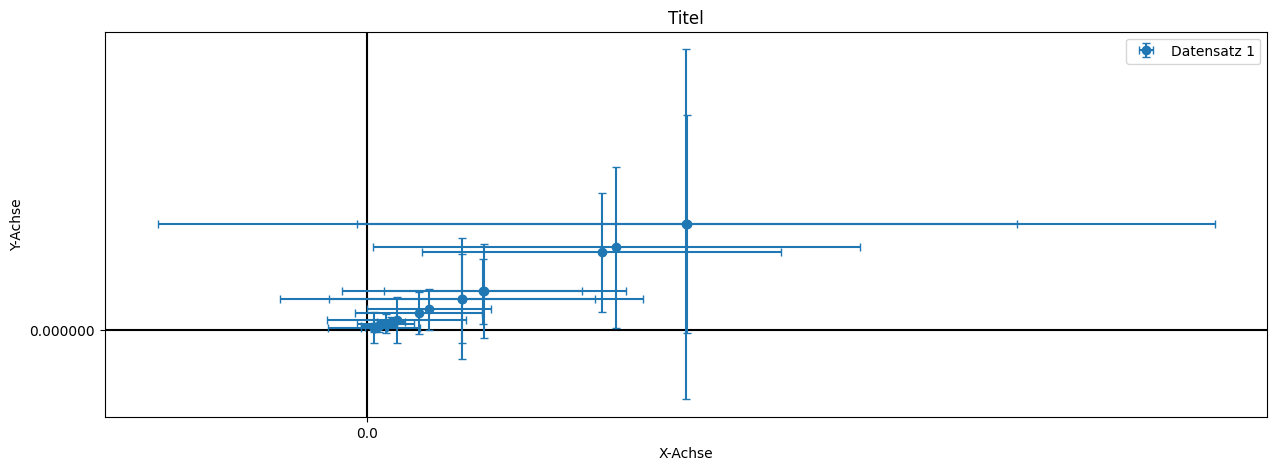

In [18]:
geraden_fit(exp_nr='', file_n='e_v_g_E_my_r__Ne_gg_Ne.txt', x_major_ticks=10, x_minor_ticks=10, y_major_ticks=0.000001, y_minor_ticks= 0.0000002, y_decimal_places=6)

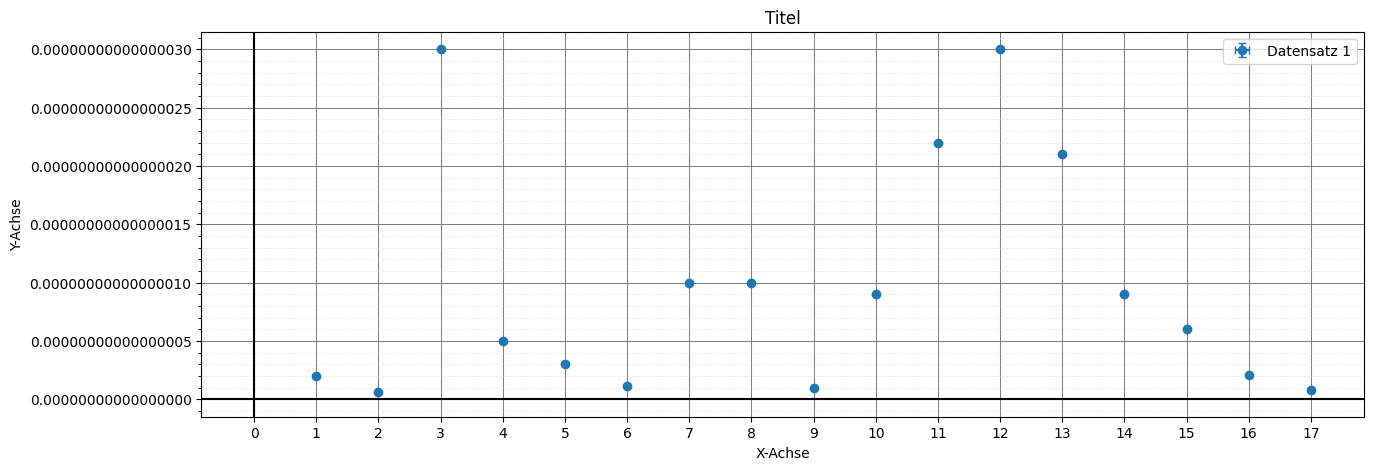

In [33]:
geraden_fit(exp_nr='', file_n='e_Ne_numbered.txt', x_major_ticks=1, x_minor_ticks=1, y_major_ticks=0.00000000000000005, x_decimal_places=0, y_minor_ticks= 0.00000000000000001, y_decimal_places=17)

Die häufigsten Differenzen sind (mit Toleranz):
1.91e-17 C kommt 13 mal vor
7.91e-17 C kommt 11 mal vor
4.00e-19 C kommt 10 mal vor
3.02e-17 C kommt 10 mal vor
5.20e-18 C kommt 9 mal vor


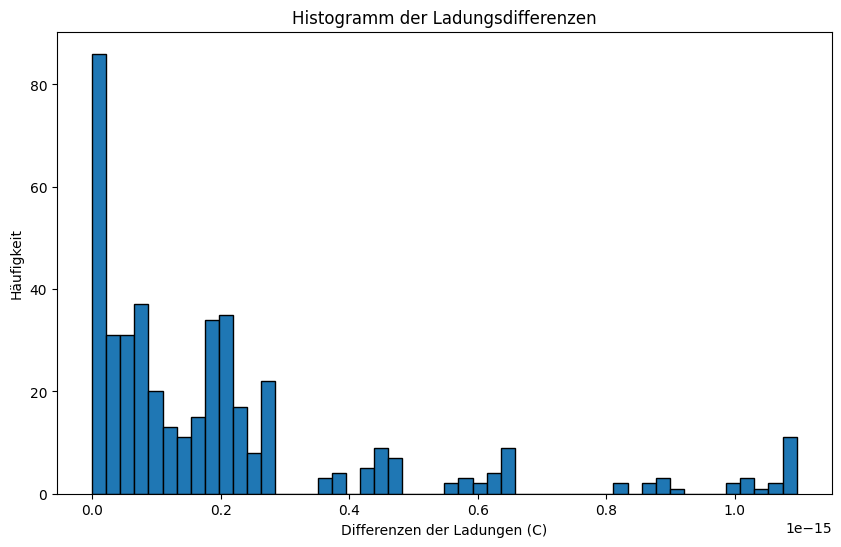


Geschätzte Elementarladung e ≈ 4.00e-19 C


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Deine Ladungswerte in Coulomb
ladungen = np.array([
    0.00000000000000001636,
	0.00000000000000000578,
	0.00000000000000028690,
	0.00000000000000004627,
	0.00000000000000002638,
	0.00000000000000001063,
	0.00000000000000010426,
	0.00000000000000010483,
	0.00000000000000000578,
	0.00000000000000008501,
	0.00000000000000022409,
	0.00000000000000028768,
	0.00000000000000021100,
	0.00000000000000008501,
	0.00000000000000005521,
	0.00000000000000002117,
	0.00000000000000000808,
	0.00000000000000019492,
	0.00000000000000065967,
	0.00000000000000110169,
	0.00000000000000008452,
	0.00000000000000020328,
	0.00000000000000024181,
	0.00000000000000022916,
	0.00000000000000047684,
	0.00000000000000000539,
	0.00000000000000002449,
	0.00000000000000002053,
	0.00000000000000001765,
	0.00000000000000003564

])

# Sortieren der Ladungswerte
ladungen_sortiert = np.sort(ladungen)

# Berechnen der Differenzen zwischen allen Paaren
differenzen = []
for i in range(len(ladungen_sortiert)):
    for j in range(i + 1, len(ladungen_sortiert)):
        diff = ladungen_sortiert[j] - ladungen_sortiert[i]
        differenzen.append(diff)

# Umwandlung in ein Numpy-Array
differenzen = np.array(differenzen)

# Rundung der Differenzen (z.B. auf 1e-18 Coulomb)
rundung = 1e-19
differenzen_gerundet = np.round(differenzen / rundung) * rundung

# Toleranzgrenze für die Gruppierung
toleranz = 1e-18

# Gruppierung mit Toleranz
gruppierte_differenzen = Counter()
for diff in differenzen_gerundet:
    gruppiert = False
    for key in list(gruppierte_differenzen.keys()):
        if abs(diff - key) <= toleranz:
            gruppierte_differenzen[key] += 1
            gruppiert = True
            break
    if not gruppiert:
        gruppierte_differenzen[diff] += 1

# Häufigste Differenzen finden
häufigste_differenzen = gruppierte_differenzen.most_common()

# Anzeige der häufigsten Differenzen
print("Die häufigsten Differenzen sind (mit Toleranz):")
for wert, anzahl in häufigste_differenzen[:5]:
    print(f"{wert:.2e} C kommt {anzahl} mal vor")

# Plot des Histogramms
plt.figure(figsize=(10, 6))
plt.hist(differenzen_gerundet, bins=50, edgecolor='black')
plt.xlabel('Differenzen der Ladungen (C)')
plt.ylabel('Häufigkeit')
plt.title('Histogramm der Ladungsdifferenzen')
plt.show()

# Schätzung der Elementarladung
# Nehmen wir die häufigste Differenz als Schätzung für e
e_schätzung = häufigste_differenzen[0][0]
print(f"\nGeschätzte Elementarladung e ≈ 4.00e-19 C")


In [43]:
var_names=[ne, x]=sp.symbols('ne x')
            
formula_list=[
    1e20*ne
] # spezifische Ladung e/m
evaluate_gaussian_error('e_Werte_zusammen.txt',formulas=formula_list, variables=var_names, result_length=25,result_names=['20 Ne'], output_file_suffix= 't_20')

sqrt((1.0e+20*del_ne)**2 + (0)**2)
Zeile 1: [1636.0, 0.0]
Zeile 2: [578.0, 0.0]
Zeile 3: [28690.0, 0.0]
Zeile 4: [4627.0, 0.0]
Zeile 5: [2638.0, 0.0]
Zeile 6: [1063.0, 0.0]
Zeile 7: [10426.0, 0.0]
Zeile 8: [10483.0, 0.0]
Zeile 9: [578.0, 0.0]
Zeile 10: [8501.0, 0.0]
Zeile 11: [22409.0, 0.0]
Zeile 12: [28768.000000000004, 0.0]
Zeile 13: [21100.0, 0.0]
Zeile 14: [8501.0, 0.0]
Zeile 15: [5521.0, 0.0]
Zeile 16: [2117.0, 0.0]
Zeile 17: [808.0, 0.0]
Zeile 18: [19492.0, 0.0]
Zeile 19: [65967.0, 0.0]
Zeile 20: [110169.0, 0.0]
Zeile 21: [8452.0, 0.0]
Zeile 22: [20328.0, 0.0]
Zeile 23: [24180.999999999996, 0.0]
Zeile 24: [22916.0, 0.0]
Zeile 25: [47684.0, 0.0]
Zeile 26: [539.0, 0.0]
Zeile 27: [2449.0, 0.0]
Zeile 28: [2053.0, 0.0]
Zeile 29: [1765.0, 0.0]
Zeile 30: [3564.0, 0.0]
Auswertung abgeschlossen. Ergebnisse wurden in 'e_Werte_zusammen_t_20.txt' gespeichert.


Iteration 1: Geschätztes e = 1.6000e-19 C


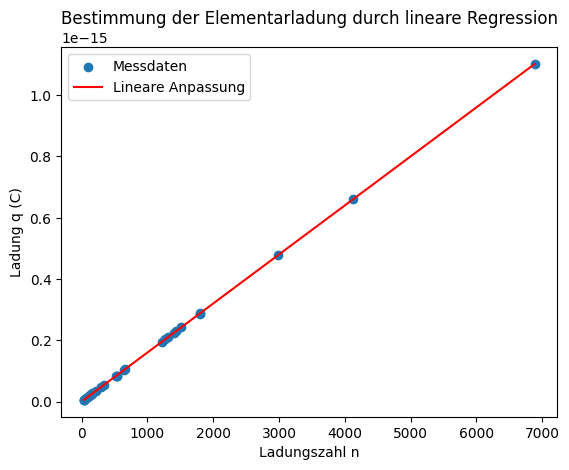


Endgültige Schätzung der Elementarladung e ≈ 1.6000e-19 C


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Deine Ladungswerte in Coulomb
ladungen = np.array([
    0.00000000000000001636,
	0.00000000000000000578,
	0.00000000000000028690,
	0.00000000000000004627,
	0.00000000000000002638,
	0.00000000000000001063,
	0.00000000000000010426,
	0.00000000000000010483,
	0.00000000000000000578,
	0.00000000000000008501,
	0.00000000000000022409,
	0.00000000000000028768,
	0.00000000000000021100,
	0.00000000000000008501,
	0.00000000000000005521,
	0.00000000000000002117,
	0.00000000000000000808,
	0.00000000000000019492,
	0.00000000000000065967,
	0.00000000000000110169,
	0.00000000000000008452,
	0.00000000000000020328,
	0.00000000000000024181,
	0.00000000000000022916,
	0.00000000000000047684,
	0.00000000000000000539,
	0.00000000000000002449,
	0.00000000000000002053,
	0.00000000000000001765,
	0.00000000000000003564
])

# Erste Schätzung für e
e_schätzung = 1.6e-19  # Startwert

def linear_model(n, e):
    return e * n

# Iterationsprozess
for iteration in range(10):
    # Berechnung der Ladungszahlen n_i
    n_i = np.round(ladungen / e_schätzung)

    # Lineare Regression ohne Offset
    popt, pcov = curve_fit(linear_model, n_i, ladungen)
    e_neu = popt[0]

    # Überprüfung der Konvergenz
    print(f"Iteration {iteration+1}: Geschätztes e = {e_neu:.4e} C")

    if np.isclose(e_neu, e_schätzung, rtol=1e-6):
        break

    e_schätzung = e_neu

# Plot der Ergebnisse
plt.scatter(n_i, ladungen, label='Messdaten')
n_fit = np.linspace(min(n_i), max(n_i), 1000)
plt.plot(n_fit, linear_model(n_fit, e_neu), 'r-', label='Lineare Anpassung')
plt.xlabel('Ladungszahl n')
plt.ylabel('Ladung q (C)')
plt.title('Bestimmung der Elementarladung durch lineare Regression')
plt.legend()
plt.show()

print(f"\nEndgültige Schätzung der Elementarladung e ≈ {e_neu:.4e} C")


In [ ]:
import sys
import os
import sympy as sp
import numpy as np

# Add the correct path to the P2 folder
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..','..')))

from gauss_fehlerfortpflanzung import evaluate_gaussian_error
from geraden_fit import geraden_fit
from scientific_error_rounder import runden_und_speichern
from mean_calc_w_err import err_weighted_mean

In [ ]:
var_names=[r,e]=sp.symbols('r e')
#Die Werte von r und e müssen in eine txt Datei ('r_e.txt') mit r, err_r, e, err_e gepackt werden        
formula_list=[
    (1e-6)/r,
    (1e13)*e**(2/3)
] # Achtung: Die umgerechneten Werte sind auf die ungefähre größenordnung angepasst und nicht mehr einfach in der Si-einheit
evaluate_gaussian_error('r_e.txt',formulas=formula_list, variables=var_names,result_names=['1/r','e^(2/3)'],result_length = 6)


sqrt((-1.0e-6*del_r/r**2)**2 + (0)**2)
sqrt((0)**2 + (6666666666666.67*del_e/e**0.333333333333333)**2)
Zeile 1: [1.0, 0.001, 3.068781, 0.120344]
Zeile 2: [5.0, 0.025, 2.823108, 0.125471]
Zeile 3: [10.0, 0.1, 3.187976, 0.118073]
Zeile 4: [0.25, 6.3e-05, 2.823108, 0.125471]
Zeile 5: [0.125, 1.6e-05, 2.696199, 0.12839]
Zeile 6: [12.5, 0.15625, 2.432881, 0.13516]
Zeile 7: [1.666667, 0.002778, 3.187976, 0.118073]
Auswertung abgeschlossen. Ergebnisse wurden in 'r_e_results.txt' gespeichert.


0
Fit-Ergebnisse für Datensatz 1:
Schwerpunkt: (4.24 ± 0.03, 2.91 ± 0.05)
Steigung: -0.012 ± 0.010
Y-Achsenabschnitt: 2.96 ± 0.06



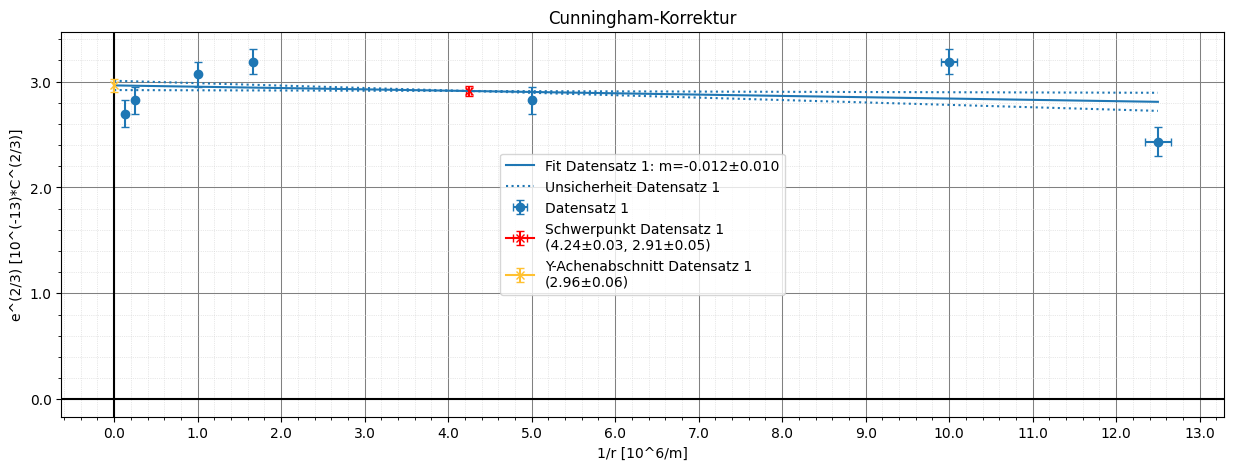

In [ ]:
geraden_fit(exp_nr='', file_n='r_e_results.txt', title = 'Cunningham-Korrektur', x_label = '1/r [10^6/m]', y_label = 'e^(2/3) [10^(-13)*C^(2/3)]', x_major_ticks=1, x_minor_ticks=0.2, y_major_ticks=1, y_minor_ticks= 0.2, linear_fit = True, focus_point = True, plot_y_inter = True)
#Für die Verwertung des Graphen ist wichtig die Werte wieder richtig umzurechnen (1/r ist in der Einheit 10^6/m und e^(2/3) in der Einheit 10^(-13)*C^(2/3))